### Wczytanie niezbędnych bibliotek

In [1]:
import re
import time

import numpy as np
import pandas as pd
import nltk
import gensim

import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

from pyMorfologik import Morfologik
from pyMorfologik.parsing import ListParser

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Conv1D, Flatten, Dropout, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


### Definicja klasy procesującej dokumenty.

In [2]:
class TokenizedDataFrame():
    __slots__ = ['stopwords', 'stemmed_dict']
    
    def __init__(self, stopwords):
        self.stopwords = stopwords
        self.stemmed_dict = None
        
    
    def prepare_text(self, doc):
        doc = re.sub(r'[^\w\s]','',doc) 
        doc = doc.lower()
        doc = nltk.word_tokenize(doc)
        doc = [word for word in doc if word not in self.stopwords]
        return doc
    
    
    def apply_stemming(self, df):
        
        parser = ListParser()
        stemmer = Morfologik()
        
        all_words = list()

        for item in list(df):
            all_words.extend(item)
    
        unique_words = list(set(all_words))
        
        self.stemmed_dict = dict()
        unique_words_stemmer = stemmer.stem(unique_words, parser)

        for item in unique_words_stemmer:
            original = item[0]
            try:
                stemmed = list(item[1])[0]
                self.stemmed_dict[original] = stemmed
            except IndexError:
                self.stemmed_dict[original] = stemmed
        
        
        missings = {item:item for item in unique_words if item not in self.stemmed_dict.keys()}
        self.stemmed_dict.update(missings)
        
        
    @staticmethod
    def remove_empty(df, col):
        return df.loc[df[col].apply(lambda x: len(x)) > 0, :]
    
       
    def transform(self, X, col, **kwargs):
        try:
            X_local = X.copy()
            X_local[col] = X_local[col].apply(self.prepare_text)
            X_local = self.remove_empty(X_local, col)
        except KeyError:
            raise KeyError("{} not present in dataframe".format(col))
            
        if not self.stemmed_dict:
            self.apply_stemming(X_local[col])
            
        X_local[col] = X_local[col].apply(lambda doc: list(map(self.stemmed_dict.get, doc)))
        X_local = X_local.reset_index(drop=True)
        
        return X_local

### Zdefiniowanie stałych

In [3]:
DATA_PATH = './data/learning_set.csv'
STOPWORDS_PATH = 'data/polish_stopwords.csv'
W2V_PATH = 'data/nkjp+wiki-forms-all-100-cbow-hs.txt'

RANDOM_STATE = 23032019

C_V = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

SCORING = 'accuracy'
N_JOBS = -1

### Wczytanie dokumentów

In [4]:
df = pd.read_csv(DATA_PATH, sep = ';')

In [5]:
df.groupby('sentiment').count()/df.shape[0]

,token
sentiment,
-1,0.102936
0,0.762434
1,0.134629


In [6]:
# import nltk
# nltk.download('punkt')

In [7]:
stopwords = list(pd.read_csv(STOPWORDS_PATH, engine='python', header=None).iloc[:, 0])



df = TokenizedDataFrame(stopwords).transform(df, 'token')

### Podział na zbiór treningowy/testowy

#### y_train/y_test używamy do sklearn API, dummy do Kerasa

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.token, 
                                                    df.sentiment, 
                                                    test_size=0.15, 
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

In [9]:
model_lr = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', tokenizer=lambda x: x,
                              preprocessor=lambda x: x, ngram_range=(1,2),
                              sublinear_tf=True)),
    ('lr', LogisticRegression(penalty='l2', random_state=RANDOM_STATE,
                              n_jobs=-1, multi_class='multinomial', solver='lbfgs')
                             )
])

model_lr.fit(x_train, y_train)


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function <lam...ty='l2', random_state=23032019, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

### Ile wynosi null accuracy?

In [10]:
print("{:.1f}%".format(100*y_train.value_counts().max()/len(y_train)))

66.9%


### Jakie accuracy na 10-krotnej CV osiąga regresja logistyczna?

In [11]:
cross_validate(model_lr, 
               x_train,
               y_train,
               cv=C_V,
               scoring=SCORING,
               n_jobs=N_JOBS, 
               return_train_score=True)\
.get('test_score')\
.mean()

0.7557665493711689

### Accuracy na zbiorze testowym

In [12]:
accuracy_score(y_test, model_lr.predict(x_test))

0.757162346521146

### Wykres krzywej uczenia

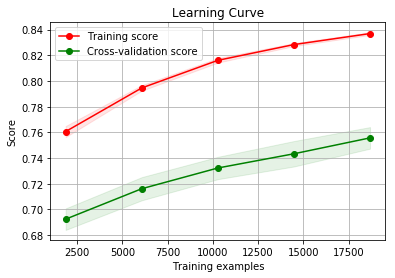

In [13]:
skplt.estimators.plot_learning_curve(model_lr,
                                     x_train,
                                     y_train,
                                     cv=C_V,
                                    random_state=RANDOM_STATE,
                                    n_jobs=N_JOBS,
                                    scoring=SCORING)
plt.show()

### Wykres słów najbardziej stymulujących skrajny sentyment według regresji

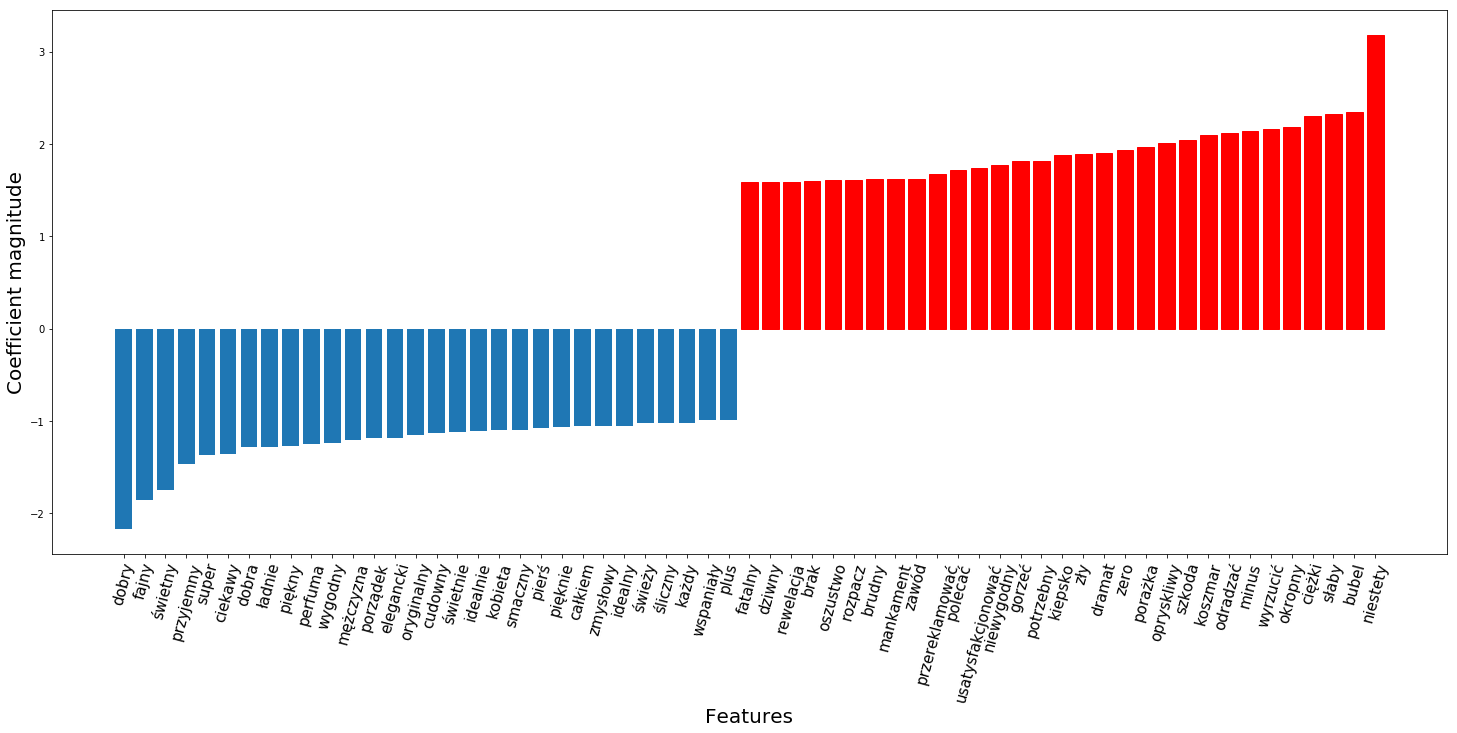

In [14]:
coefficients = model_lr.named_steps.get('lr').coef_
index = coefficients.argsort()

feature_names = np.array(model_lr.named_steps.get('tfidf').get_feature_names())
feature_names_comb = list(feature_names[index][0][:30]) + list(feature_names[index][0][-31::1])

index_comb = list(coefficients[0][index[0][:30]]) + list(coefficients[0][index[0][-31::1]])

plt.figure(figsize=(25,10))
barlist = plt.bar(list(i for i in range(61)), index_comb)
plt.xticks(list(i for i in range(61)),feature_names_comb,rotation=75,size=15)
plt.ylabel('Coefficient magnitude',size=20)
plt.xlabel('Features',size=20)

# color the first smallest 30 bars red
for i in range(30, 61):
    barlist[i].set_color('red')

plt.show()

### Zdefiniowanie funkcji wczytującej embeddingi, klasy procesującej dane do sieci neuronowej i samej sieci.

In [17]:
def non_trivial_sentence(sentence):
    len_words = [True if len(i) > 1 else 0 for i in sentence]
    return any(len_words)

def init(): # tutaj ładujemy embeddingi i zapisujemy do globalnej zmiennej żeby zawsze było je widać
  
    global w2vModel
    w2vModel = load_w2v_embeddings(W2V_PATH)

        
def get_embeddings(): # ładujemyy ebeddingi jeśli jeszcze ich nie ma w zmiennej globalnej a jak są to zwracamy

    global w2vModel
    try:
        return w2vModel
    except NameError:
        init()
        return w2vModel


def load_w2v_embeddings(path): # ładujemy embeddingi gensimem
    w2vModel = gensim.models.KeyedVectors.load_word2vec_format(path, 
                                                               binary=False)
    return w2vModel 

class FixedSizeArray(BaseEstimator, TransformerMixin): # Transformer for transforming given data into undersoodable form for neural network
    def __init__(self, dimensions, steps, word2vec_mod=None):
        self.dim = dimensions
        self.steps = steps
        self.w2v = word2vec_mod
        
    def fit_transform(self, texts, y=None):
        return self.transform(texts, y)
    
    def fit(self, texts):
        return None
    
    def _transform(self, article): # przyjmujemy jedno zdanie i wypluwamy wektor o długości 10 i każdy element to wektor 100 wymiarowy
        #tokens = CountVectorizer().build_tokenizer()(article) 
        doc_vectors_gen = (self.w2v[a].tolist() for a in article if a in self.w2v.vocab) # przetwarzamy każde słowo na wektor
        doc_vectors = [a for (i, a) in enumerate(doc_vectors_gen) if i < self.steps] # upierdalamy po 10 słowach
        
        while len(doc_vectors) < self.steps: # jeśli nie ma 10 słów to dodajemy 0
            doc_vectors.append([0])
    
        pad_vectors = pad_sequences(doc_vectors,padding='post',dtype='float32', maxlen=self.dim, value=0.) # uzupełniamy te 0 żeby też były 100 wymairowe
        return pad_vectors
    
    def transform(self, sentences, y=None): 
        
        if self.w2v == None: # jesli nie ma embeddingów to ładujemy
            print("Lazy loading embeddings...")
            self.w2v = get_embeddings()
        
        return np.array([self._transform(i) for i in sentences])
    
    
def plot_training(history): # plot training history
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def create_conv_model(dropout, input_shape, kernel_size=3): 
    model = Sequential()
    model.add(Conv1D(64, kernel_size, input_shape=(input_shape, 100), padding='same'))
    model.add(Conv1D(32, kernel_size, padding='same'))
    model.add(Conv1D(16, kernel_size, padding='same'))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(180, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    return model

def create_simple_LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape = (10, 100), return_sequences=True))
    model.add(SpatialDropout1D(0.5))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(3,activation='softmax'))
    return model

def create_LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape = (input_shape, 100), return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model


def create_Dense_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(1000,), activation='relu'))
    #model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model


class NeuralNet(BaseEstimator, ClassifierMixin): 
    
    def __init__(self, model, name='', validation_size=0.2, batchsize = 256, epochs = 10):
        self.model = model
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.early_stopping = EarlyStopping(patience=2) # early stopping callback
        self.batchsize = batchsize
        self.epochs = epochs
        self.validation_size = validation_size
        
    def fit(self, X, y):
        
        history = self.model.fit(X, 
                                 y, 
                                 validation_split=self.validation_size, 
                                 batch_size=self.batchsize, 
                                 epochs=self.epochs, 
                                 callbacks=[self.early_stopping])
        self.history = history
        
    def predict(self, X):
        return self.model.predict(X)

In [18]:
def get_accuracy_score(estimator):
    pred = estimator.predict(x_test).argmax(axis=1)-1
    return accuracy_score(y_test, pred)

## Prosty dense

In [19]:
model_dense = create_Dense_model()

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
fsa = FixedSizeArray(100, 10)

In [21]:
a = fsa.transform(x_train)

Lazy loading embeddings...


In [22]:
a = a.reshape(-1, 10*100)

In [23]:
a.shape

(20767, 1000)

In [24]:
model_dense.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [25]:
model_dense.fit(a, dummy_y_train, epochs = 10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20767/20767 [==============================] - ETA: 2:02 - loss: 0.6427 - acc: 0.697 - ETA: 5s - loss: 0.5985 - acc: 0.7488  - ETA: 2s - loss: 0.5599 - acc: 0.763 - ETA: 1s - loss: 0.5160 - acc: 0.777 - ETA: 1s - loss: 0.4963 - acc: 0.783 - ETA: 1s - loss: 0.4790 - acc: 0.787 - ETA: 1s - loss: 0.4734 - acc: 0.788 - ETA: 0s - loss: 0.4642 - acc: 0.791 - ETA: 0s - loss: 0.4597 - acc: 0.792 - ETA: 0s - loss: 0.4544 - acc: 0.795 - ETA: 0s - loss: 0.4481 - acc: 0.797 - ETA: 0s - loss: 0.4410 - acc: 0.800 - ETA: 0s - loss: 0.4378 - acc: 0.800 - ETA: 0s - loss: 0.4326 - acc: 0.803 - ETA: 0s - loss: 0.4299 - acc: 0.804 - ETA: 0s - loss: 0.4255 - acc: 0.806 - ETA: 0s - loss: 0.4217 - acc: 0.807 - ETA: 0s - loss: 0.4195 - acc: 0.809 - ETA: 0s - loss: 0.4179 - acc: 0.809 - ETA: 0s - loss: 0.4147 - acc: 0.810 - 1s 59us/step - loss: 0.4142 - acc: 0.8105
Epoch 2/10
20767/20767 [==============================] - ETA: 1s - loss: 0.1950 - acc: 

20767/20767 [==============================] - ETA: 1s - loss: 0.1310 - acc: 0.947 - ETA: 1s - loss: 0.1332 - acc: 0.950 - ETA: 1s - loss: 0.1360 - acc: 0.946 - ETA: 1s - loss: 0.1342 - acc: 0.948 - ETA: 0s - loss: 0.1343 - acc: 0.949 - ETA: 0s - loss: 0.1356 - acc: 0.948 - ETA: 0s - loss: 0.1353 - acc: 0.948 - ETA: 0s - loss: 0.1356 - acc: 0.947 - ETA: 0s - loss: 0.1371 - acc: 0.947 - ETA: 0s - loss: 0.1379 - acc: 0.947 - ETA: 0s - loss: 0.1424 - acc: 0.945 - ETA: 0s - loss: 0.1456 - acc: 0.944 - ETA: 0s - loss: 0.1468 - acc: 0.943 - ETA: 0s - loss: 0.1479 - acc: 0.943 - ETA: 0s - loss: 0.1497 - acc: 0.943 - ETA: 0s - loss: 0.1503 - acc: 0.942 - ETA: 0s - loss: 0.1503 - acc: 0.942 - ETA: 0s - loss: 0.1512 - acc: 0.942 - ETA: 0s - loss: 0.1512 - acc: 0.941 - ETA: 0s - loss: 0.1510 - acc: 0.941 - ETA: 0s - loss: 0.1532 - acc: 0.940 - ETA: 0s - loss: 0.1548 - acc: 0.940 - ETA: 0s - loss: 0.1557 - acc: 0.940 - 1s 54us/step - loss: 0.1560 - acc: 0.9399
Epoch 10/10
20767/20767 [============

### Prosty LSTM

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Lazy loading embeddings...
Train on 16613 samples, validate on 4154 samples
Epoch 1/10
16613/16613 [==============================] - ETA: 1:28 - loss: 0.6472 - acc: 0.666 - ETA: 45s - loss: 0.6388 - acc: 0.666 - ETA: 31s - loss: 0.6336 - acc: 0.66 - ETA: 24s - loss: 0.6308 - acc: 0.66 - ETA: 19s - loss: 0.6284 - acc: 0.66 - ETA: 17s - loss: 0.6252 - acc: 0.66 - ETA: 14s - loss: 0.6220 - acc: 0.66 - ETA: 13s - loss: 0.6166 - acc: 0.65 - ETA: 12s - loss: 0.6119 - acc: 0.66 - ETA: 11s - loss: 0.6078 - acc: 0.66 - ETA: 10s - loss: 0.6030 - acc: 0.66 - ETA: 9s - loss: 0.5989 - acc: 0.6701 - ETA: 9s - loss: 0.5945 - acc: 0.675 - ETA: 8s - loss: 0.5914 - acc: 0.680 - ETA: 8s - loss: 0.5856 - acc: 0.686 - ETA: 7s - loss: 0.5823 - acc: 0.691 - ETA: 7s - loss: 0.5776 - acc: 0.696 - ETA: 6s - loss: 0.5737 - acc: 0.700 - ETA: 6s - loss: 0.5684 - acc: 0.705 - ETA: 6s - loss: 0.5644 - 

16613/16613 [==============================] - ETA: 3s - loss: 0.3270 - acc: 0.849 - ETA: 3s - loss: 0.3005 - acc: 0.865 - ETA: 4s - loss: 0.2958 - acc: 0.868 - ETA: 3s - loss: 0.2972 - acc: 0.866 - ETA: 3s - loss: 0.2842 - acc: 0.870 - ETA: 3s - loss: 0.2849 - acc: 0.870 - ETA: 3s - loss: 0.2887 - acc: 0.866 - ETA: 3s - loss: 0.2894 - acc: 0.865 - ETA: 3s - loss: 0.2866 - acc: 0.867 - ETA: 3s - loss: 0.2877 - acc: 0.868 - ETA: 3s - loss: 0.2877 - acc: 0.868 - ETA: 3s - loss: 0.2897 - acc: 0.867 - ETA: 3s - loss: 0.2885 - acc: 0.869 - ETA: 3s - loss: 0.2921 - acc: 0.867 - ETA: 3s - loss: 0.2941 - acc: 0.866 - ETA: 3s - loss: 0.2952 - acc: 0.865 - ETA: 3s - loss: 0.2947 - acc: 0.866 - ETA: 3s - loss: 0.2947 - acc: 0.864 - ETA: 2s - loss: 0.2938 - acc: 0.865 - ETA: 2s - loss: 0.2957 - acc: 0.865 - ETA: 2s - loss: 0.2939 - acc: 0.866 - ETA: 2s - loss: 0.2933 - acc: 0.866 - ETA: 2s - loss: 0.2939 - acc: 0.866 - ETA: 2s - loss: 0.2941 - acc: 0.865 - ETA: 2s - loss: 0.2959 - acc: 0.864 - ETA

16613/16613 [==============================] - ETA: 3s - loss: 0.2410 - acc: 0.898 - ETA: 3s - loss: 0.2294 - acc: 0.902 - ETA: 3s - loss: 0.2443 - acc: 0.899 - ETA: 3s - loss: 0.2437 - acc: 0.899 - ETA: 3s - loss: 0.2495 - acc: 0.893 - ETA: 3s - loss: 0.2516 - acc: 0.894 - ETA: 3s - loss: 0.2441 - acc: 0.897 - ETA: 3s - loss: 0.2402 - acc: 0.897 - ETA: 3s - loss: 0.2397 - acc: 0.898 - ETA: 3s - loss: 0.2366 - acc: 0.899 - ETA: 3s - loss: 0.2359 - acc: 0.898 - ETA: 3s - loss: 0.2324 - acc: 0.899 - ETA: 3s - loss: 0.2331 - acc: 0.899 - ETA: 3s - loss: 0.2344 - acc: 0.898 - ETA: 3s - loss: 0.2355 - acc: 0.899 - ETA: 3s - loss: 0.2369 - acc: 0.898 - ETA: 3s - loss: 0.2349 - acc: 0.899 - ETA: 2s - loss: 0.2363 - acc: 0.898 - ETA: 2s - loss: 0.2359 - acc: 0.899 - ETA: 2s - loss: 0.2350 - acc: 0.899 - ETA: 2s - loss: 0.2350 - acc: 0.899 - ETA: 2s - loss: 0.2355 - acc: 0.898 - ETA: 2s - loss: 0.2353 - acc: 0.898 - ETA: 2s - loss: 0.2347 - acc: 0.899 - ETA: 2s - loss: 0.2361 - acc: 0.898 - ETA

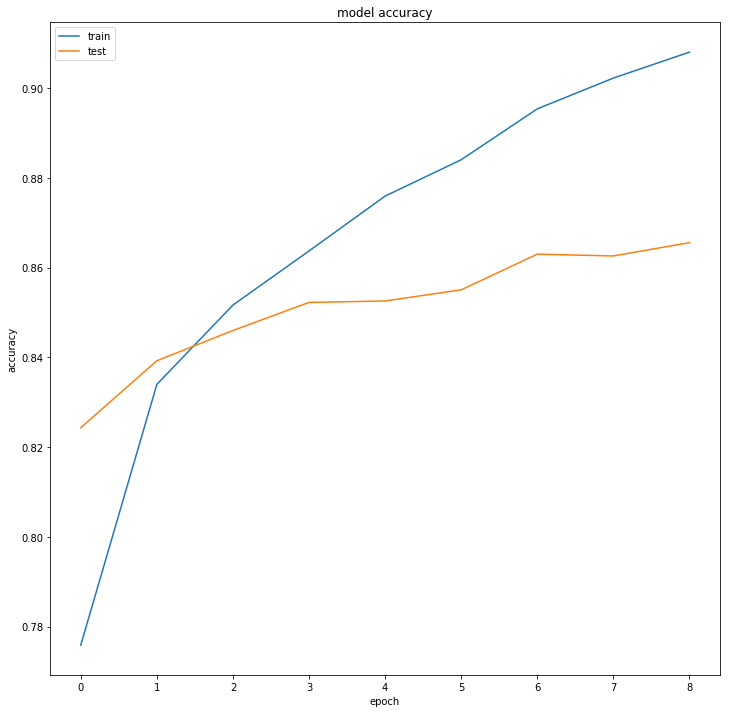

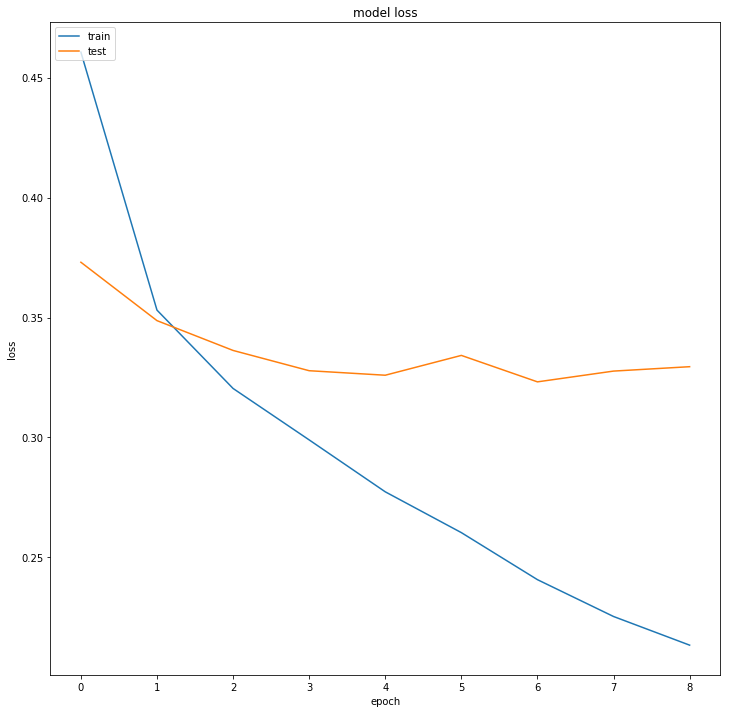

In [26]:
model_simple_lstm = Pipeline([
    ('fsa', FixedSizeArray(100,10)),
    ('nn', NeuralNet(create_simple_LSTM_model(10), 'simple_LSTM')),
])  # written classes can be used with sklearn Pipeline class

model_simple_lstm.fit(x_train, dummy_y_train)

plot_training(model_simple_lstm.steps[1][1].history) 

In [27]:
get_accuracy_score(model_simple_lstm)

0.792905866302865

### LSTM

Lazy loading embeddings...
Train on 16613 samples, validate on 4154 samples
Epoch 1/10
16613/16613 [==============================] - ETA: 2:36 - loss: 0.6418 - acc: 0.666 - ETA: 1:22 - loss: 0.6319 - acc: 0.666 - ETA: 58s - loss: 0.6211 - acc: 0.665 - ETA: 45s - loss: 0.6109 - acc: 0.66 - ETA: 38s - loss: 0.6072 - acc: 0.66 - ETA: 33s - loss: 0.5959 - acc: 0.67 - ETA: 29s - loss: 0.5906 - acc: 0.68 - ETA: 27s - loss: 0.5869 - acc: 0.69 - ETA: 25s - loss: 0.5852 - acc: 0.69 - ETA: 23s - loss: 0.5789 - acc: 0.70 - ETA: 21s - loss: 0.5736 - acc: 0.71 - ETA: 20s - loss: 0.5708 - acc: 0.71 - ETA: 19s - loss: 0.5654 - acc: 0.72 - ETA: 18s - loss: 0.5602 - acc: 0.72 - ETA: 17s - loss: 0.5565 - acc: 0.72 - ETA: 17s - loss: 0.5515 - acc: 0.73 - ETA: 16s - loss: 0.5491 - acc: 0.73 - ETA: 15s - loss: 0.5463 - acc: 0.73 - ETA: 15s - loss: 0.5443 - acc: 0.73 - ETA: 14s - loss: 0.5406 - acc: 0.74 - ETA: 13s - loss: 0.5374 - acc: 0.74 - ETA: 13s - loss: 0.5336 - acc: 0.74 - ETA: 12s - loss: 0.5304 -

16613/16613 [==============================] - ETA: 11s - loss: 0.2746 - acc: 0.88 - ETA: 11s - loss: 0.2974 - acc: 0.86 - ETA: 11s - loss: 0.3082 - acc: 0.85 - ETA: 11s - loss: 0.3085 - acc: 0.85 - ETA: 11s - loss: 0.3077 - acc: 0.85 - ETA: 11s - loss: 0.3165 - acc: 0.85 - ETA: 10s - loss: 0.3188 - acc: 0.84 - ETA: 10s - loss: 0.3130 - acc: 0.85 - ETA: 10s - loss: 0.3159 - acc: 0.85 - ETA: 10s - loss: 0.3143 - acc: 0.85 - ETA: 10s - loss: 0.3131 - acc: 0.85 - ETA: 10s - loss: 0.3102 - acc: 0.85 - ETA: 10s - loss: 0.3077 - acc: 0.85 - ETA: 9s - loss: 0.3113 - acc: 0.8544 - ETA: 9s - loss: 0.3109 - acc: 0.854 - ETA: 9s - loss: 0.3099 - acc: 0.853 - ETA: 9s - loss: 0.3082 - acc: 0.855 - ETA: 8s - loss: 0.3084 - acc: 0.856 - ETA: 8s - loss: 0.3097 - acc: 0.855 - ETA: 8s - loss: 0.3093 - acc: 0.854 - ETA: 8s - loss: 0.3090 - acc: 0.854 - ETA: 7s - loss: 0.3073 - acc: 0.854 - ETA: 7s - loss: 0.3078 - acc: 0.855 - ETA: 7s - loss: 0.3067 - acc: 0.856 - ETA: 7s - loss: 0.3067 - acc: 0.856 - ET

16613/16613 [==============================] - ETA: 12s - loss: 0.2575 - acc: 0.87 - ETA: 11s - loss: 0.2482 - acc: 0.87 - ETA: 11s - loss: 0.2428 - acc: 0.88 - ETA: 11s - loss: 0.2468 - acc: 0.88 - ETA: 10s - loss: 0.2553 - acc: 0.88 - ETA: 10s - loss: 0.2479 - acc: 0.88 - ETA: 10s - loss: 0.2535 - acc: 0.88 - ETA: 10s - loss: 0.2511 - acc: 0.88 - ETA: 10s - loss: 0.2490 - acc: 0.88 - ETA: 10s - loss: 0.2446 - acc: 0.89 - ETA: 10s - loss: 0.2463 - acc: 0.88 - ETA: 9s - loss: 0.2446 - acc: 0.8907 - ETA: 9s - loss: 0.2447 - acc: 0.892 - ETA: 9s - loss: 0.2434 - acc: 0.890 - ETA: 9s - loss: 0.2475 - acc: 0.889 - ETA: 8s - loss: 0.2487 - acc: 0.888 - ETA: 8s - loss: 0.2495 - acc: 0.887 - ETA: 8s - loss: 0.2509 - acc: 0.886 - ETA: 8s - loss: 0.2517 - acc: 0.886 - ETA: 8s - loss: 0.2527 - acc: 0.886 - ETA: 8s - loss: 0.2554 - acc: 0.885 - ETA: 7s - loss: 0.2572 - acc: 0.884 - ETA: 7s - loss: 0.2574 - acc: 0.884 - ETA: 7s - loss: 0.2566 - acc: 0.885 - ETA: 7s - loss: 0.2566 - acc: 0.885 - ET

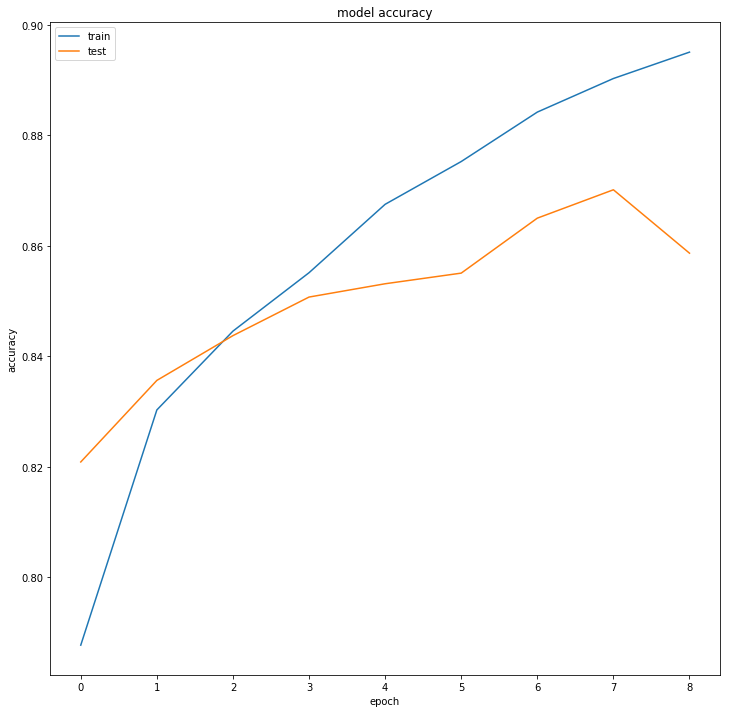

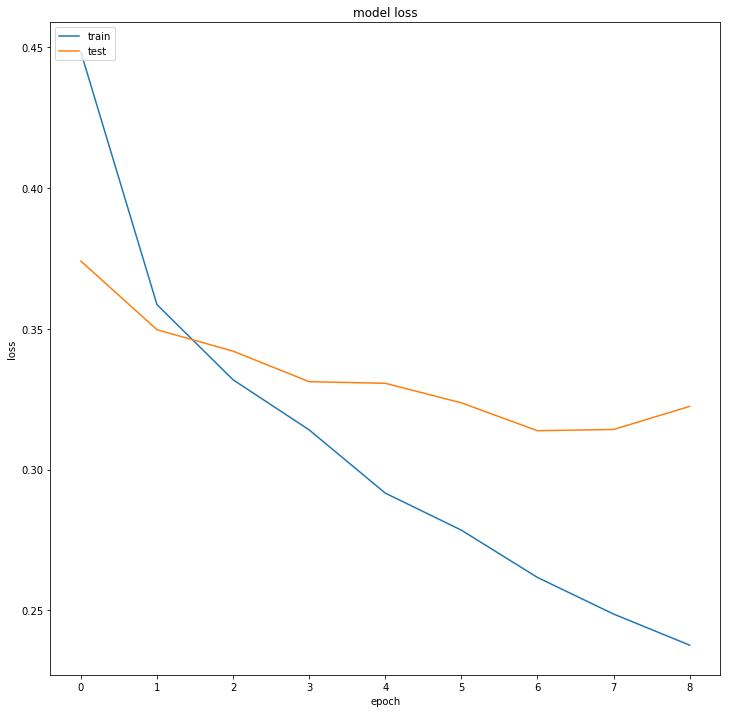

In [28]:
model_lstm = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_LSTM_model(10), 'not_simple_LSTM')),
])

model_lstm.fit(x_train, dummy_y_train)

plot_training(model_lstm.steps[1][1].history) 

In [29]:
get_accuracy_score(model_lstm)

0.7893587994542974

### Conv1d

Lazy loading embeddings...
Train on 16613 samples, validate on 4154 samples
Epoch 1/10
16613/16613 [==============================] - ETA: 55s - loss: 0.8825 - acc: 0.61 - ETA: 14s - loss: 0.8071 - acc: 0.65 - ETA: 6s - loss: 0.7453 - acc: 0.6808 - ETA: 4s - loss: 0.7181 - acc: 0.697 - ETA: 3s - loss: 0.6892 - acc: 0.709 - ETA: 2s - loss: 0.6672 - acc: 0.721 - ETA: 2s - loss: 0.6532 - acc: 0.727 - ETA: 1s - loss: 0.6424 - acc: 0.731 - ETA: 1s - loss: 0.6344 - acc: 0.734 - ETA: 1s - loss: 0.6285 - acc: 0.736 - ETA: 1s - loss: 0.6192 - acc: 0.739 - ETA: 0s - loss: 0.6112 - acc: 0.743 - ETA: 0s - loss: 0.6042 - acc: 0.745 - ETA: 0s - loss: 0.5972 - acc: 0.748 - ETA: 0s - loss: 0.5929 - acc: 0.750 - ETA: 0s - loss: 0.5870 - acc: 0.752 - ETA: 0s - loss: 0.5801 - acc: 0.754 - ETA: 0s - loss: 0.5758 - acc: 0.756 - ETA: 0s - loss: 0.5680 - acc: 0.758 - 2s 129us/step - loss: 0.5652 - acc: 0.7594 - val_loss: 0.4336 - val_acc: 0.8029
Epoch 2/10
16613/16613 [==============================] - ETA: 

16613/16613 [==============================] - ETA: 1s - loss: 0.3847 - acc: 0.809 - ETA: 0s - loss: 0.3522 - acc: 0.830 - ETA: 0s - loss: 0.3423 - acc: 0.842 - ETA: 0s - loss: 0.3448 - acc: 0.845 - ETA: 0s - loss: 0.3381 - acc: 0.848 - ETA: 0s - loss: 0.3427 - acc: 0.845 - ETA: 0s - loss: 0.3403 - acc: 0.847 - ETA: 0s - loss: 0.3404 - acc: 0.846 - ETA: 0s - loss: 0.3421 - acc: 0.846 - ETA: 0s - loss: 0.3434 - acc: 0.845 - ETA: 0s - loss: 0.3449 - acc: 0.843 - ETA: 0s - loss: 0.3475 - acc: 0.842 - ETA: 0s - loss: 0.3474 - acc: 0.842 - ETA: 0s - loss: 0.3456 - acc: 0.842 - ETA: 0s - loss: 0.3437 - acc: 0.842 - ETA: 0s - loss: 0.3444 - acc: 0.842 - ETA: 0s - loss: 0.3440 - acc: 0.843 - ETA: 0s - loss: 0.3435 - acc: 0.843 - ETA: 0s - loss: 0.3449 - acc: 0.842 - ETA: 0s - loss: 0.3439 - acc: 0.843 - 1s 71us/step - loss: 0.3446 - acc: 0.8426 - val_loss: 0.3686 - val_acc: 0.8295
Epoch 10/10
16613/16613 [==============================] - ETA: 1s - loss: 0.3094 - acc: 0.862 - ETA: 1s - loss: 0

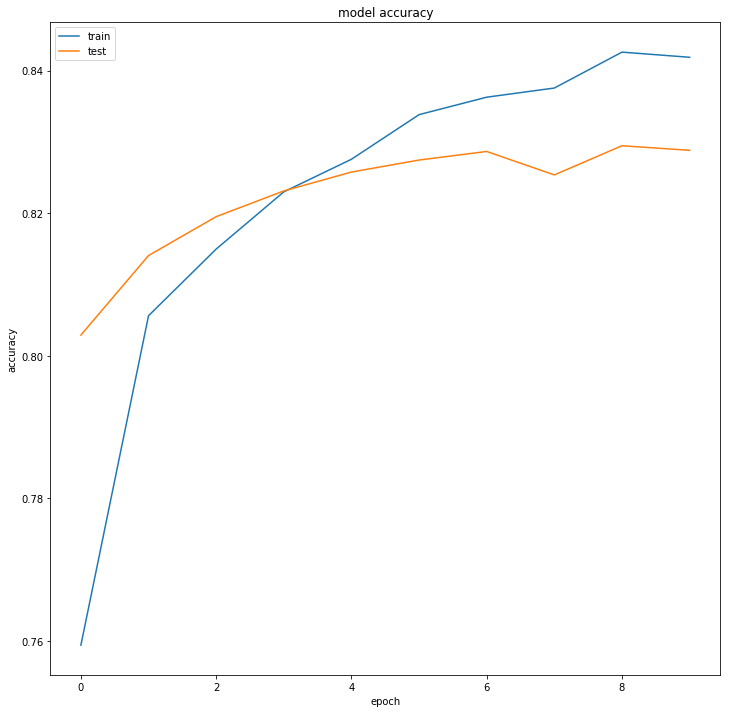

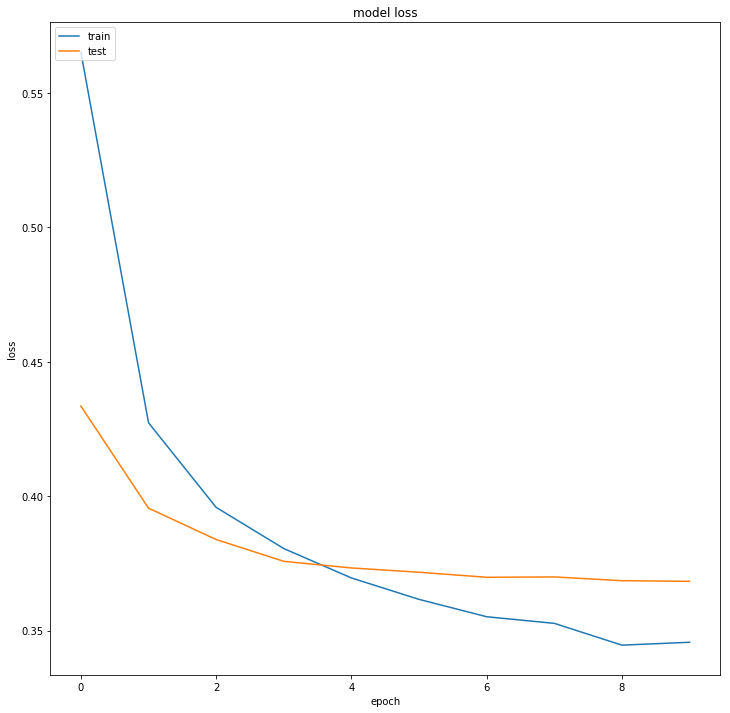

In [30]:
model_conv = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_conv_model(0.3, 10), 'conv_1d')),
])

model_conv.fit(x_train, dummy_y_train)

plot_training(model_conv.steps[1][1].history) 

In [31]:
get_accuracy_score(model_conv)

0.7405184174624829

### Jak wczytać dane do challenge'u?

In [32]:
scoring_set = pd.read_csv("./data/challenge_set_warsztat.csv", sep = ';')
scoring_set = TokenizedDataFrame(stopwords).transform(scoring_set, 'token')

### Jak stworzyć i zapisać predykcję?

In [33]:
# dla sklearn API
pred = model_lr.predict(scoring_set.token)

In [34]:
# dla Keras
pred = model_simple_lstm.predict(scoring_set.token).argmax(axis=1)-1

In [35]:
assert len(pred) == 5022

### Wektor zapisany przez np.save należy przesłać do nas na e-mail

In [36]:
np.save('nickname', pred)